In [1]:
# Step 0: Import Datasets
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("D:/Placement Preparation/Dog_detection/lfw/lfw/*/*"))
dog_files = np.array(glob("D:/Placement Preparation/Dog_detection/dog_images/train/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))


There are 13233 total human images.
There are 6680 total dog images.


Number of faces detected: 1


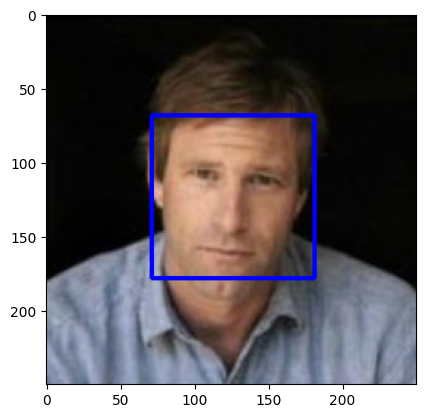

In [2]:
# Step 1: Detect Humans
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x, y, w, h) in faces:
    # add bounding box to color image
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()


In [4]:
# (IMPLEMENTATION) Assess the Human Face Detector
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

def percentageOfDetectingFaces(detector, img_paths):
    count = 0
    for img_path in img_paths:
        if detector(img_path):
            count += 1
    return count / len(img_paths) * 100

def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0


print("The percentage of the human images that include a detected, human face: {:.2f}%.".format(
    percentageOfDetectingFaces(face_detector, human_files_short)))
print("The percentage of the dog images that include a detected, human face: {:.2f}%.".format(
    percentageOfDetectingFaces(face_detector, dog_files_short)))


The percentage of the human images that include a detected, human face: 96.00%.
The percentage of the dog images that include a detected, human face: 4.00%.


In [5]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()


C:\Users\Abhishek\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Abhishek\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    img = Image.open(img_path)
    transform = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
    img_tensor = transform(img)
    img_tensor.unsqueeze_(0)
    
    if use_cuda:
        img_tensor = img_tensor.cuda()

    prediction = VGG16(img_tensor)
    
    if use_cuda:
        prediction = prediction.cpu()
    
    return prediction.data.numpy().argmax() # predicted class index


In [9]:
from PIL import Image
import torchvision.transforms as transforms
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    index = VGG16_predict(img_path)
    return index >= 151 and index <= 268 # true/false


print("The percentage of the human images that include a detected, dog face: {:.2f}%.".format(
    percentageOfDetectingFaces(dog_detector, human_files_short)))
print("The percentage of the dog images that include a detected, dog face: {:.2f}%.".format(
    percentageOfDetectingFaces(dog_detector, dog_files_short)))


The percentage of the human images that include a detected, dog face: 0.00%.
The percentage of the dog images that include a detected, dog face: 92.00%.


In [23]:
from torchvision import datasets

# # Define a custom dataset class that handles truncated images
# class CustomImageDataset(datasets.ImageFolder):
#     def __getitem__(self, index):
#         try:
#             return super().__getitem__(index)
#         except Exception as e:
#             print(f"Error loading image at index {index}: {e}")
#             # Handle the error, e.g., by returning a placeholder or skipping the image
#             # You can return a default image, None, or raise an exception based on your needs

In [35]:
from torchvision import datasets

class CustomImageDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except Exception as e:
            print(f"Error loading image at index {index}: {e}")
            # Return a placeholder or default image tensor
            placeholder_image = torch.zeros(3, 224, 224)  # Replace with appropriate dimensions
            target = -1  # Invalid target value
            return placeholder_image, target



In [29]:
import os
from torchvision import datasets

# Specify data loaders
data_dir = 'D:/Placement Preparation/Dog_detection/dog_images'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'valid/')
test_dir = os.path.join(data_dir, 'test/')

# data_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# train_data = datasets.ImageFolder(train_dir, transform=data_transform)
# valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)
# test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# # Specify batch size
# batch_size = 20

# # Create data loaders
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define data transforms
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create data loaders using the custom dataset class
train_data = CustomImageDataset(train_dir, transform=data_transform)
valid_data = CustomImageDataset(valid_dir, transform=data_transform)
test_data = CustomImageDataset(test_dir, transform=data_transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)



# Print out some data statistics
print('Num training images: ', len(train_data))
print('Num valid images: ', len(valid_data))
print('Num test images: ', len(test_data))


Num training images:  6680
Num valid images:  835
Num test images:  836


In [30]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 500)
        self.fc2 = nn.Linear(500, 133)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the CNN
model_scratch = Net()
print(model_scratch)

# Move the model to GPU if available
if use_cuda:
    model_scratch.cuda()


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [31]:
import torch.optim as optim
import torch.nn.functional as F

# Select loss function
criterion_scratch = nn.CrossEntropyLoss()

# Select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.9)


In [43]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0
        
        # Train the model
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            if batch_idx == 5255:
                continue
            
            valid_samples = target != -1
            data, target = data[valid_samples], target[valid_samples]
            if len(data) == 0:
            
             optimizer.zero_grad()
             output = model(data)
             loss = criterion(output, target)
             loss.backward()
             optimizer.step()
             train_loss = train_loss + loss.item()
            #  train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        # Validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            if batch_idx == 5255:
                continue
            
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
   
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
        ))
        
        # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    
      
    return model

loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}



# Train the model
model_scratch = train(20, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

# Load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))


Error loading image at index 5255: image file is truncated (148 bytes not processed)
Epoch: 1 	Training Loss: 0.000000 	Validation Loss: 4.625513
Validation loss decreased (inf --> 4.625513).  Saving model ...
Error loading image at index 5255: image file is truncated (148 bytes not processed)
Epoch: 2 	Training Loss: 0.000000 	Validation Loss: 4.631698
Error loading image at index 5255: image file is truncated (148 bytes not processed)
Epoch: 3 	Training Loss: 0.000000 	Validation Loss: 4.572313
Validation loss decreased (4.625513 --> 4.572313).  Saving model ...


KeyboardInterrupt: 

In [44]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0
        
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            valid_samples = target != -1
            data, target = data[valid_samples], target[valid_samples]
            
            if len(data) == 0:
                continue  # Skip empty batch
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * data.size(0)  # Accumulate the loss
            
        train_loss /= len(loaders['train'].dataset)  # Calculate the average training loss
        
        # Validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            if batch_idx == 5255:
                continue
            
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
   
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
        ))
        
        # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    
      
    return model 



loaders_scratch = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}



# Train the model
model_scratch = train(20, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

# Load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))


Error loading image at index 5255: image file is truncated (148 bytes not processed)
Epoch: 1 	Training Loss: 4.509786 	Validation Loss: 4.485154
Validation loss decreased (inf --> 4.485154).  Saving model ...
Error loading image at index 5255: image file is truncated (148 bytes not processed)
Epoch: 2 	Training Loss: 4.459613 	Validation Loss: 4.457378
Validation loss decreased (4.485154 --> 4.457378).  Saving model ...
Error loading image at index 5255: image file is truncated (148 bytes not processed)
Epoch: 3 	Training Loss: 4.403899 	Validation Loss: 4.471266
Error loading image at index 5255: image file is truncated (148 bytes not processed)
Epoch: 4 	Training Loss: 4.337715 	Validation Loss: 4.376614
Validation loss decreased (4.457378 --> 4.376614).  Saving model ...
Error loading image at index 5255: image file is truncated (148 bytes not processed)
Epoch: 5 	Training Loss: 4.275305 	Validation Loss: 4.351802
Validation loss decreased (4.376614 --> 4.351802).  Saving model ...

In [ ]:
def test(loaders, model, criterion, use_cuda):
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        with torch.no_grad():
            output = model(data)
            loss = criterion(output, target)
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
            pred = output.data.max(1, keepdim=True)[1]
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [ ]:
# Specify data loaders (already done)
loaders_transfer = loaders_scratch

model_transfer = models.vgg16(pretrained=True)

if use_cuda:
    model_transfer = model_transfer.cuda()

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, 133)
model_transfer.classifier[6] = last_layer

# Move the model to GPU if available
if use_cuda:
    model_transfer.cuda()


In [ ]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

In [ ]:
# Train the model
model_transfer = train(70, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# Load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

# Test the model
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)


In [ ]:
def predict_breed_transfer(img_path):
    img = Image.open(img_path)
    transform = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
    img_tensor = transform(img)
    img_tensor.unsqueeze_(0)
    if use_cuda:
        img_tensor = img_tensor.cuda()
    prediction = model_transfer(img_tensor)
    if use_cuda:
        prediction = prediction.cpu()
    return prediction.data.numpy().argmax()

In [ ]:
def run_app(img_path):
    face_detected = face_detector(img_path)
    dog_detected = dog_detector(img_path)
    pred = predict_breed_transfer(img_path)

    if dog_detected and not face_detected:
        title = "Hello, dog!\nYour predicted breed is...\n{}!".format(class_names[pred])
    elif not dog_detected and face_detected:
        title = "Hello, human!\nYou look like a {}!".format(class_names[pred])
    elif dog_detected and face_detected:
        title = "Hello, human!\nThat's a nice {} you've got there!".format(class_names[pred])  
    else:
        title = "I can't find any dogs or humans here..."

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.gca().set_title(title)
    plt.show()

# Test the algorithm on custom images
for file in np.array(glob("customized_files/*")):
    run_app(file)
